# Jira Ticket Age

In [1]:
# SPDX-License-Identifier: Apache-2.0
# Licensed to the Ed-Fi Alliance under one or more agreements.
# The Ed-Fi Alliance licenses this file to you under the Apache License, Version 2.0.
# See the LICENSE and NOTICES files in the project root for more information.

from edfi_tech_metrics.settings import load_from_env
from edfi_tech_metrics.jira import JiraBrowser
from edfi_tech_metrics.ticket_age import get_age_unresolved_tickets, build_report_components

conf = load_from_env()
browser = JiraBrowser(conf)

projects = ["DMS", "ADMINAPI"]
df = get_age_unresolved_tickets(conf, browser, projects)

Connecting to https://tracker.ed-fi.org
Retrieving tickets for DMS
Retrieving tickets for ADMINAPI


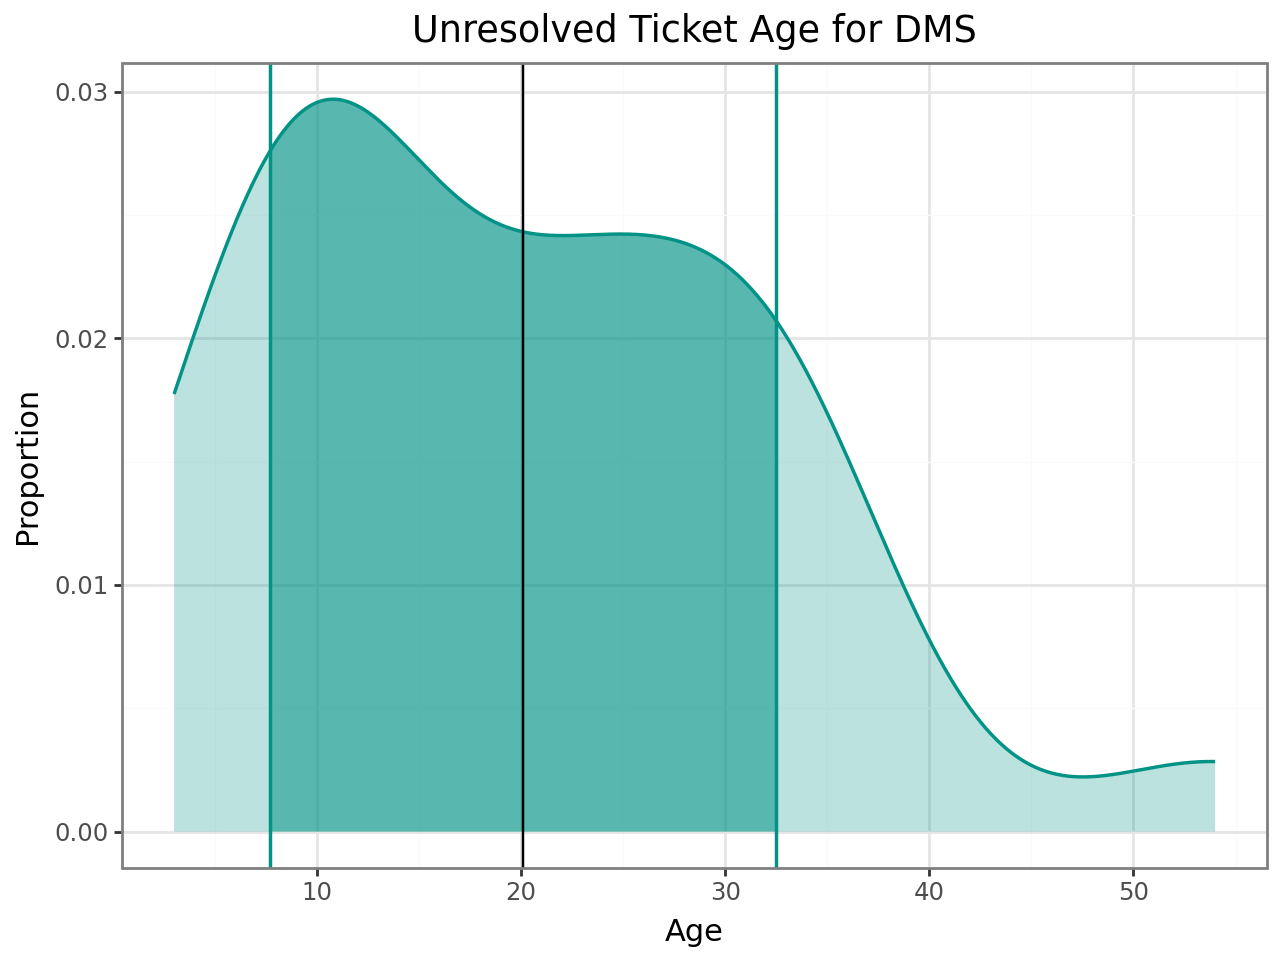

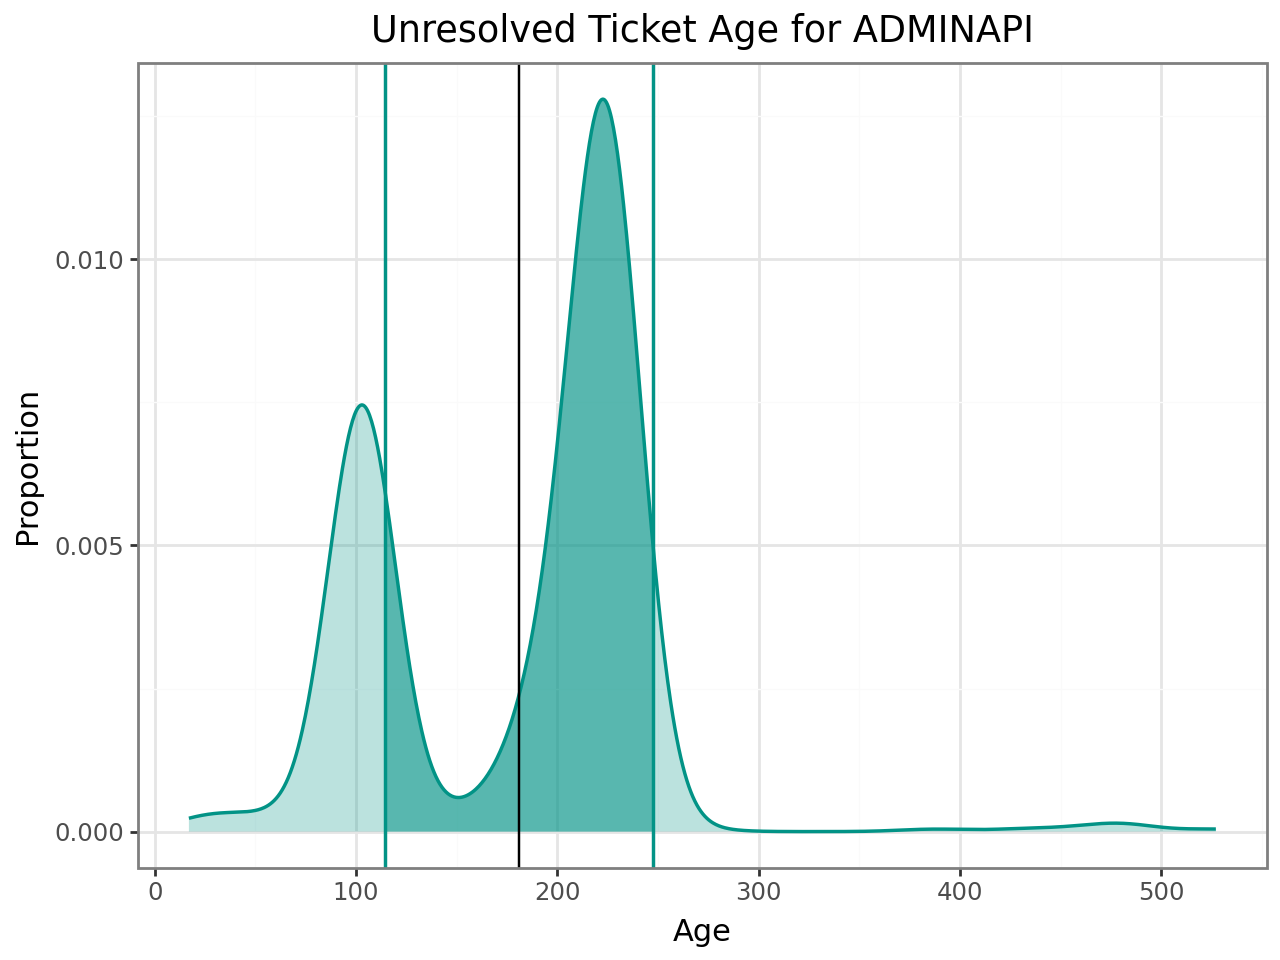

In [14]:
stats = build_report_components(projects, df)
for s in stats:
    s.histogram.show()

In [ ]:
import pandas as pd
from datetime import datetime

stats_df = pd.concat([s.stats for s in stats])

today = datetime.today().strftime('%Y-%m-%d')

stats_df["date"] = today
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "project"}, inplace=True)

file_name = f"./data/ticket-age-{today}.csv"
conf.info(f"Writing data out to file: {file_name}")
stats_df.to_csv(file_name)

stats_df